In [1]:
## conda env Weather_Prediction

import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import GridSearchCV
from scipy.stats import pearsonr

from tensorflow import keras ## pip install tensorflow

In [2]:
## load the data

full_df = pd.read_pickle("2010_data.pkl")
full_df=full_df.drop(columns=['location_name', 'fips', 'year', 'NAME', 'geometry'],axis=1)
pd.set_option('display.max_columns', None)
full_df=full_df.dropna() ## get rid of NaN as MLP cannot handle it
full_df

,MeanLifeExpectency,d2m,t2m,bcaod550,chnk,duaod550,lai_hv,lai_lv,msl,omaod550,pm2p5,pm10,ssaod550,asn,rsn,sd,suaod550,sp,tsn,aod550,tcco,tc_c2h6,tchcho,tc_oh,tc_c5h8,tc_ch4,tc_hno3,tcno2,tc_no,gtco3,tc_pan,tc_c3h8,tcso2,tcw,tcwv,aermssdus,aermssdum,aermssdul,aermssbchphil,aermssomhphil,aermssbchphob,aermssomhphob,aermsssss,aermssssm,aermssssl,aermsssu,aermssso2
0,75.728489,283.454410,291.089093,0.006284,0.01800,0.010721,3.928873,2.633910,101693.509736,0.075966,1.445389e-08,1.981001e-08,0.007574,0.878745,271.096109,0.005542,0.071412,100187.304165,272.665101,0.171956,0.000890,0.000003,4.351195e-06,4.876012e-09,3.973694e-06,0.009891,0.000005,0.000003,4.658415e-07,0.006583,0.000009,6.953380e-07,2.916594e-06,25.766945,25.620820,2.109251e-06,4.289945e-06,3.297524e-06,1.285140e-07,0.000003,5.390907e-07,0.000013,2.305156e-07,0.000016,1.011381e-06,0.000008,1.620365e-06
1,77.826608,286.767193,292.241782,0.006410,0.01527,0.013597,3.930011,2.508253,101685.471788,0.072641,1.346257e-08,1.847324e-08,0.010417,0.879538,193.698250,0.004818,0.069880,101309.280631,275.408300,0.172946,0.000875,0.000003,3.513297e-06,4.926652e-09,2.062545e-06,0.010006,0.000005,0.000003,4.380713e-07,0.006433,0.000008,6.623504e-07,2.408668e-06,27.838995,27.701486,2.641386e-06,5.453165e-06,4.363785e-06,1.200844e-07,0.000002,5.609629e-07,0.000013,2.891494e-07,0.000021,2.088636e-06,0.000008,1.140217e-06
2,75.841973,284.124711,291.030084,0.006434,0.01800,0.010576,4.154440,2.339233,101690.626048,0.073790,1.528844e-08,2.094088e-08,0.007874,0.879026,245.431868,0.006236,0.067283,100229.513473,272.708199,0.165957,0.000885,0.000003,4.161191e-06,4.878442e-09,3.484876e-06,0.009897,0.000005,0.000003,4.412445e-07,0.006521,0.000009,6.841318e-07,2.561723e-06,26.076443,25.936913,2.072566e-06,4.220296e-06,3.329836e-06,1.460098e-07,0.000002,5.375428e-07,0.000013,2.383421e-07,0.000016,1.124706e-06,0.000008,1.212712e-06
3,73.705432,283.448675,290.734945,0.006233,0.01800,0.010422,3.859579,2.695780,101696.274163,0.077023,1.467121e-08,2.014099e-08,0.007201,0.878604,274.363643,0.005314,0.073008,100215.778699,272.652578,0.173887,0.000894,0.000003,4.369584e-06,4.879895e-09,3.844808e-06,0.009893,0.000005,0.000004,5.053737e-07,0.006622,0.000009,7.044878e-07,3.263775e-06,25.607194,25.458810,2.049331e-06,4.173433e-06,3.204589e-06,1.257123e-07,0.000003,5.365352e-07,0.000013,2.220161e-07,0.000015,9.132320e-07,0.000008,1.971961e-06
4,75.753407,282.868247,289.766565,0.006107,0.01800,0.008332,3.234586,2.781183,101710.006570,0.077158,1.519334e-08,2.097774e-08,0.006178,0.877193,276.665988,0.006156,0.074710,99027.783845,272.614234,0.172485,0.000889,0.000003,4.043741e-06,4.893173e-09,2.631260e-06,0.009770,0.000005,0.000004,5.254242e-07,0.006689,0.000009,7.188703e-07,3.696579e-06,24.042930,23.889293,1.644247e-06,3.319324e-06,2.564080e-06,1.292652e-07,0.000003,5.195765e-07,0.000013,1.988160e-07,0.000013,7.093172e-07,0.000008,2.447597e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3122,77.582422,268.842111,278.301219,0.004760,0.01800,0.004101,2.370862,0.499930,101630.449624,0.043633,7.253336e-09,1.103061e-08,0.005092,0.798388,288.873684,0.016426,0.023886,78530.596578,268.911264,0.081471,0.000644,0.000003,1.057299e-06,4.941603e-09,8.047194e-08,0.007655,0.000003,0.000002,4.937694e-07,0.006915,0.000005,5.093373e-07,1.734801e-06,7.928388,7.855770,5.407217e-07,1.250976e-06,3.762784e-06,9.304454e-08,0.000002,4.126463e-07,0.000008,2.043045e-07,0.000013,9.202822e-07,0.000003,1.312529e-06
3123,83.771012,267.887551,274.410086,0.004909,0.01800,0.001664,2.481296,2.428177,101634.772736,0.046080,6.861324e-09,9.790676e-09,0.006100,0.807739,305.402204,0.095034,0.021758,75497.845779,268.751272,0.080511,0.000615,0.000003,8.352510e-07,4.851321e-09,7.964809e-08,0.007339,0.000003,0.000001,2.701267e-07,0.007030,0.000004,4.969263e-07,5.508047e-07,6.659885,6.563536,2.826886e-07,6.105456e

In [3]:
## Lets create a Train-Test set

features=full_df.drop('MeanLifeExpectency',axis=1)
target=full_df['MeanLifeExpectency'].copy()

## a validataion is not required as we can create it when training the model
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.20) 

In [4]:
## scale the features as it will converge to the cost function faster

scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train) 
X_test_scaled=scaler.transform(X_test) 

In [5]:
## build a MLP with 2 dense layer using sequential API

model=keras.models.Sequential([
## below is the first dense dense layer with 30 neurons ( or units), relu activation function
## its a good practice to specify the input shape as well, and only include in the first layer
                            keras.layers.Dense(60, activation='relu', input_shape=X_train.shape[1:]),
## lets create a second layer. Its not quite necessary as it is only a regression task
                            keras.layers.Dense(30, activation='relu'),
## create a output layer. Since, the output is only 1, create the output layer with 1 unit
                            keras.layers.Dense(1)
                               ]) 

C:\Users\Shisir\.conda\envs\Weather_Prediction\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
model.summary() ## None means that the batch size can be anything

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 60)             │         2,820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 30)             │         1,830 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,681 (18.29 KB)

 Trainable params: 4,681 (18.29 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
## compile the model with mse ( mean squared error) as a loss function
## Adam optimizer to find the optimal solution
## note that, sgd did not work and provided the same output.
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='mean_squared_error', optimizer= optimizer)

In [8]:
history= model.fit(X_train_scaled, y_train, epochs=150,
                    validation_split=0.2) ## a validation set to optimize the weights and biases

Epoch 1/150
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5590.5415 - val_loss: 3826.8850
Epoch 2/150
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2759.8059 - val_loss: 790.5009
Epoch 3/150
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 589.6808 - val_loss: 380.1512
Epoch 4/150
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 299.5072 - val_loss: 197.9453
Epoch 5/150
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 182.2335 - val_loss: 116.1030
Epoch 6/150
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 109.2258 - val_loss: 79.4578
Epoch 7/150
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 75.2374 - val_loss: 59.4114
Epoch 8/150
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 59.6606 - val_loss: 46.7122
Epoch 9/150
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 40.6742 - val_loss: 37.5554
Epoch 10/150
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 37.0762 - val_loss: 31.2566
Epoch 11/150
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 32.3204 - val_loss: 26.7268
Epoch 12/150
62/62 ━━━━━━━━

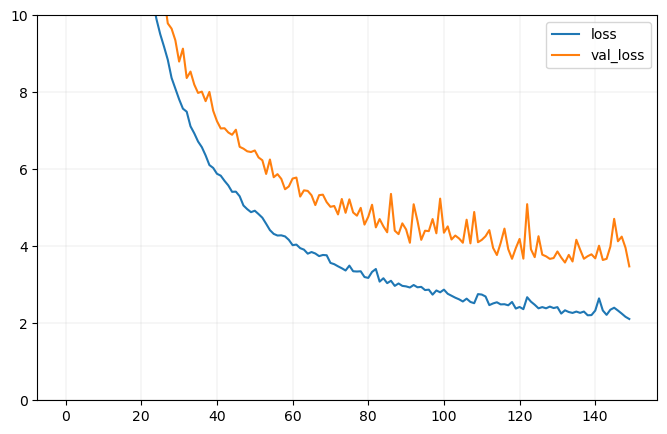

In [9]:
## plot the train and validation loss

pd.DataFrame(history.history).plot(figsize=(8, 5)) 
plt.grid(axis='both',linewidth=0.15)
## set the ylim as the validation loss is way high in the first epoch
plt.gca().set_ylim(0, 10) 
plt.show()

#### The validation loss is close to the training loss and is starting to plateau, so its good enough.

In [10]:
mse_train=model.evaluate(X_train_scaled, y_train)
mse_test=model.evaluate(X_test_scaled, y_test)

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1329
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.8062 


In [11]:
train_prediction=model.predict(X_train_scaled).flatten()
test_prediction=model.predict(X_test_scaled).flatten()

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [12]:
y_train=y_train.to_numpy()
y_test=y_test.to_numpy()

In [13]:
train_prediction

array([73.960236, 77.88983 , 76.10592 , ..., 79.44603 , 76.23552 ,
       76.7719  ], dtype=float32)

In [14]:
## train rmse

mse_train=mean_squared_error(y_train, train_prediction)
rmse_train=np.sqrt(mse_train)
rmse_train=int(rmse_train*100)/100 ## display only two digits without rounding

print('The train RMSE :::', '%.2f' % rmse_train)

## test rmse

mse_test=mean_squared_error(y_test,test_prediction)
rmse_test=np.sqrt(mse_test)
rmse_test=int(rmse_test*100)/100 

print('The test RMSE :::', '%.2f' % rmse_test)

The train RMSE ::: 1.52
The test RMSE ::: 1.64


In [15]:
## the train r square

train_r_sq=(pearsonr(y_train,train_prediction)[0])**2
corr_train=int(train_r_sq*100)/100 ## display only two digits without rounding

print('The train r_sq :::', '%.2f' % corr_train)
## The test r square

test_r_sq=(pearsonr(y_test,test_prediction)[0])**2
corr_test=int(test_r_sq*100)/100 ## display only two digits without rounding

print('The test r_sq :::', '%.2f' % corr_test)

The train r_sq ::: 0.59
The test r_sq ::: 0.50


### The results are again worse than Random Forest, I wont draw the scatter plot and qqplots.